<a href="https://colab.research.google.com/github/chinmayee232000/notes_or_not_identificationdl/blob/main/notes_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from skimage import io
import pandas as pd


In [2]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform_train=transforms.Compose([ transforms.ToPILImage(),transforms.RandomResizedCrop(224),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),])
transform_test=transforms.Compose([ transforms.ToPILImage(),transforms.RandomResizedCrop(224),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class notesornot(Dataset):
  def __init__(self,csv_files,root_dir,transform=transform_train):
    self.annotations=pd.read_csv(csv_files)
    self.root_dir=root_dir
    self.transform=transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=os.path.join(self.root_dir,self.annotations.iloc[index,0])
    image=io.imread(img_path)
    y_label=torch.tensor(int(self.annotations.iloc[index,1]))
    if self.transform:
      image=self.transform(image)
    return (image,y_label)


In [6]:
dataset=notesornot(csv_files='/content/drive/MyDrive/notes_non.csv', root_dir='/content/drive/MyDrive/NOTES',transform=transform_train)

In [7]:
train_set,test_set=torch.utils.data.random_split(dataset,[200,51])

In [15]:
num_classes=2
batch_size=4
trainloader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)


In [16]:
from torchvision import models
resnet=models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [18]:
for param in resnet.parameters():
 param.requires_grad=False
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,num_classes)
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)
    

torch.Size([2, 512])
torch.Size([2])


In [20]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    print(inputs.shape,labels.shape)    
    return 100 * correct / total


In [24]:
import copy
from copy import deepcopy
max_epochs=100

In [29]:
from torchvision import models
resnet=models.resnet18(pretrained=True)
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.RMSprop(resnet.parameters(),lr=0.05)
loss_epoch_ar=[]
max_epochs=100
min_loss=1000
n_iters = np.ceil(50000/batch_size)


Streaming output truncated to the last 5000 lines.
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([4, 3, 224, 224]) torch.Size([4])
Epoch: 7/100, Test acc: 96.08, Train acc: 88.50
Min loss 0.00
Iteration: 0/12500, Loss: 1.69
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0

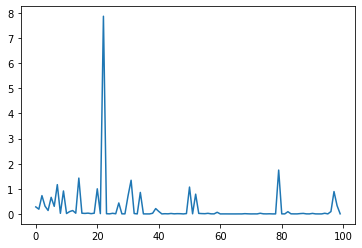

In [30]:
for epoch in range(max_epochs):
  for i,data in enumerate(trainloader,0):
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    opt.zero_grad()
    outputs=resnet(inputs)
    loss= loss_fn(outputs,labels)
    loss.backward()
    opt.step()
    if min_loss>loss.item():
      min_loss=loss.item()
    best_model= copy.deepcopy(resnet.state_dict())
    print('Min loss %0.2f' % min_loss)
    if i%100==0:
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
    del inputs, labels, outputs
    torch.cuda.empty_cache()
        
  loss_epoch_ar.append(loss.item())
        
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
plt.plot(loss_epoch_ar)
plt.show()

In [31]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader,resnet), evaluation(testloader,resnet))

torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([3, 3, 224, 224]) torch.Size([3])
100.0 100.0
